<a href="https://colab.research.google.com/github/fatemafaria142/Comparative-Analysis-of-Variants-of-UNet-Architectures-for-Gastrointestinal-Polyp-Segmentation/blob/main/Gastrointestinal_Polyp_Segmentation_using_UNet_Plus_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras_unet_collection import models, losses
import tensorflow as tf
from datetime import datetime
import cv2
import random
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
dataset = load_dataset("kowndinya23/Kvasir-SEG")

Generating train split:   0%|          | 0/880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/120 [00:00<?, ? examples/s]

In [6]:
# Get an overview of the dataset features and splits
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['name', 'image', 'annotation'],
        num_rows: 880
    })
    validation: Dataset({
        features: ['name', 'image', 'annotation'],
        num_rows: 120
    })
})


In [7]:
import os
from datasets import load_dataset
from PIL import Image

# Load the dataset
dataset = load_dataset("kowndinya23/Kvasir-SEG")

# Define paths to our training, test, and validation Images
train_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/train/Original/'
test_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/test/Original/'
validation_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/validation/Original/'

# Define paths to our training, test, and validation Masks
train_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/train/Ground truth/'
test_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/test/Ground truth/'
validation_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/validation/Ground truth/'

# Create directories if they don't exist
for directory in [train_image_directory, test_image_directory, validation_image_directory,
                  train_masks_directory, test_masks_directory, validation_masks_directory]:
    os.makedirs(directory, exist_ok=True)

# Split train and test data
train_images = dataset['train']['image'][120:]  # Take remaining images for train
train_masks = dataset['train']['annotation'][120:]
test_images = dataset['train']['image'][:120]  # Take first 120 images for test
test_masks = dataset['train']['annotation'][:120]

# Save train images and masks
for idx, (image, mask) in enumerate(zip(train_images, train_masks)):
    image.save(os.path.join(train_image_directory, f'{idx}.png'))
    mask.save(os.path.join(train_masks_directory, f'{idx}.png'))

# Save test images and masks
for idx, (image, mask) in enumerate(zip(test_images, test_masks)):
    image.save(os.path.join(test_image_directory, f'{idx}.png'))
    mask.save(os.path.join(test_masks_directory, f'{idx}.png'))

# Save validation images and masks
for idx, (image, mask) in enumerate(zip(dataset['validation']['image'], dataset['validation']['annotation'])):
    image.save(os.path.join(validation_image_directory, f'{idx}.png'))
    mask.save(os.path.join(validation_masks_directory, f'{idx}.png'))


# **Dataset Directory**

In [8]:
# Define paths to our training, test, and validation Images
train_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/train/Original/'
test_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/test/Original/'
validation_image_directory = '/content/drive/MyDrive/gastrointestinal_polyp/validation/Original/'

# Define paths to our training, test, and validation Masks
train_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/train/Ground truth/'
test_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/test/Ground truth/'
validation_masks_directory = '/content/drive/MyDrive/gastrointestinal_polyp/validation/Ground truth/'

# **Train dataset**

In [9]:
train_image_dataset = []
train_mask_dataset = []
SIZE = 224  # Assuming the desired size for the images is 224 X 224

train_images = os.listdir(train_image_directory)
for i, image_name in enumerate(train_images):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(train_image_directory, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_image_dataset.append(np.array(image))

train_masks = os.listdir(train_masks_directory)
for i, image_name in enumerate(train_masks):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(train_masks_directory, image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_dataset.append(np.array(image))

# Normalize images
train_image_data = np.array(train_image_dataset) / 255.0
# Rescale masks to 0 to 1
train_mask_data = np.expand_dims(np.array(train_mask_dataset), 3) / 255.0

# **Checking random images from train dataset**

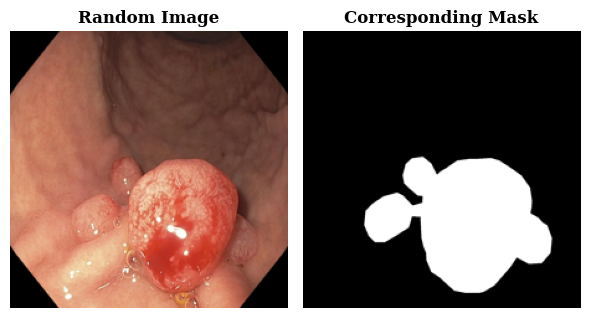

In [10]:
# Display a random image along with its mask
random_index = random.randint(0, len(train_image_data) - 1)
random_image = train_image_data[random_index]
random_mask = train_mask_data[random_index]

plt.figure(figsize=(6, 4))

# Display the random image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Random Image',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask[:, :, 0], cmap='gray')  # Assuming the mask is a single-channel image
plt.title('Corresponding Mask',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

plt.tight_layout()
plt.show()

# **Test Dataset**

In [15]:
test_image_dataset = []
test_mask_dataset = []
SIZE = 224  # Assuming the desired size for the images is 224 X 224

test_images = os.listdir(test_image_directory)
for i, image_name in enumerate(test_images):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(test_image_directory, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_image_dataset.append(np.array(image))

test_masks = os.listdir(test_masks_directory)
for i, image_name in enumerate(test_masks):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(test_masks_directory, image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_mask_dataset.append(np.array(image))

# Normalize images
test_image_data = np.array(test_image_dataset) / 255.0
# Rescale masks to 0 to 1
test_mask_data = np.expand_dims(np.array(test_mask_dataset), 3) / 255.0

# **Checking random images from test dataset**

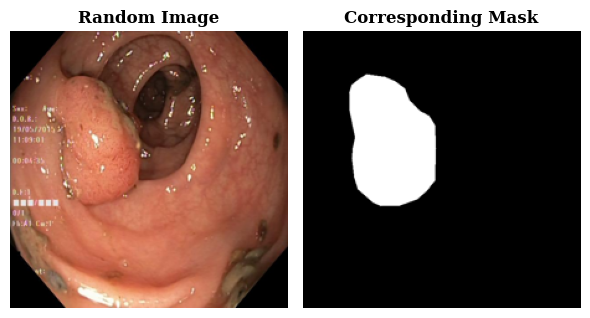

In [12]:
# Display a random image along with its mask
random_index = random.randint(0, len(test_image_data) - 1)
random_image = test_image_data[random_index]
random_mask = test_mask_data[random_index]

plt.figure(figsize=(6, 4))

# Display the random image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Random Image',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask[:, :, 0], cmap='gray')  # Assuming the mask is a single-channel image
plt.title('Corresponding Mask',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

plt.tight_layout()
plt.show()

# **Validation Dataset**

In [13]:
validation_image_dataset = []
validation_mask_dataset = []
SIZE = 224  # Assuming the desired size for the images is 224 X 224

validation_images = os.listdir(test_image_directory)
for i, image_name in enumerate(validation_images):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(test_image_directory, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        validation_image_dataset.append(np.array(image))

validation_masks = os.listdir(test_masks_directory)
for i, image_name in enumerate(test_masks):
    if image_name.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(test_masks_directory, image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        validation_mask_dataset.append(np.array(image))

# Normalize images
validation_image_data = np.array(validation_image_dataset) / 255.0
# Rescale masks to 0 to 1
validation_mask_data = np.expand_dims(np.array(validation_mask_dataset), 3) / 255.0

# **Checking random images from validation dataset**

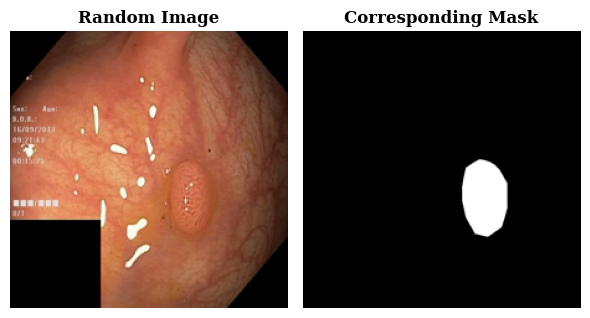

In [14]:
# Display a random image along with its mask
random_index = random.randint(0, len(validation_image_data) - 1)
random_image = validation_image_data[random_index]
random_mask = validation_mask_data[random_index]

plt.figure(figsize=(6, 4))

# Display the random image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Random Image',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask[:, :, 0], cmap='gray')  # Assuming the mask is a single-channel image
plt.title('Corresponding Mask',fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
plt.axis('off')

plt.tight_layout()
plt.show()

# **Segmnetation Model: UNet**
# **Backbone:**
* **DenseNet121**
* **DenseNet169**
* **DenseNet201**


In [23]:
###############################################################################
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS = 3
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 1


model_Unet_plus = models.unet_plus_2d((224, 224, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='DenseNet169', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.001),
              metrics=['accuracy', losses.dice_coef])

print(model_Unet_plus.summary())

51877672/51877672 [==============================] - 0s 0us/step
Model: "unet_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 DenseNet169_backbone (Func  [(None, 112, 112, 64),    6641728   
 tional)                      (None, 56, 56, 128),               
                              (None, 28, 28, 256),               
                              (None, 14, 14, 640)]               
                                                                 
 unet_plus_up0_from3_decode  (None, 28, 28, 512)       2949632   
 _trans_conv (Conv2DTranspo                                      
 se)                                                             
                                                                 
 unet_plus_up0_from3_decode  (None, 28, 28, 512)    

# **Training starts here...**

In [24]:
start1 = datetime.now()

Unet_history = model_Unet_plus.fit(train_image_data, train_mask_data,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(validation_image_data, validation_mask_data),
                    shuffle=False,
                    epochs=10)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)



Epoch 1/10
760/760 [==============================] - 71s 73ms/step - loss: 0.2630 - accuracy: 0.8947 - dice_coef: 0.5034 - val_loss: 0.2087 - val_accuracy: 0.9159 - val_dice_coef: 0.6245
Epoch 2/10
760/760 [==============================] - 52s 68ms/step - loss: 0.2134 - accuracy: 0.9135 - dice_coef: 0.5816 - val_loss: 0.2068 - val_accuracy: 0.9155 - val_dice_coef: 0.6174
Epoch 3/10
760/760 [==============================] - 48s 63ms/step - loss: 0.1862 - accuracy: 0.9239 - dice_coef: 0.6239 - val_loss: 0.2036 - val_accuracy: 0.9185 - val_dice_coef: 0.6432
Epoch 4/10
760/760 [==============================] - 49s 64ms/step - loss: 0.1629 - accuracy: 0.9328 - dice_coef: 0.6618 - val_loss: 0.1955 - val_accuracy: 0.9236 - val_dice_coef: 0.6479
Epoch 5/10
760/760 [==============================] - 48s 64ms/step - loss: 0.1420 - accuracy: 0.9403 - dice_coef: 0.6935 - val_loss: 0.1785 - val_accuracy: 0.9279 - val_dice_coef: 0.6792
Epoch 6/10
760/760 [==============================] - 48s 64

# **Saved the trained model for the 1st time**

In [25]:
from tensorflow.keras.models import load_model
# Assuming 'model_Unet' is our trained UNet model
model_Unet_plus.save('/content/drive/MyDrive/UNets/Gastrointestinal_UNet_Plus_DenseNet169_10epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Load the trained model for training again**

In [ ]:
'''
# To load the saved model later
loaded_model = load_model('/content/drive/MyDrive/UNets/Gastrointestinal_Polyp_UNet_EfficientNetB0_30epochs.hdf5')
'''

In [ ]:
'''
# Assuming 'loaded_model' is the model loaded from the saved file
loaded_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),
                     metrics=['accuracy'])


start2 = datetime.now()

# Continue training the loaded model for additional epochs
start_epoch = 31
end_epoch = 60
additional_epochs = end_epoch - start_epoch + 1  # Calculate the number of epochs to train

loaded_model_history = loaded_model.fit(train_image_data, train_mask_data,
                                        verbose=1,
                                        batch_size=batch_size,
                                        validation_data=(validation_image_data, validation_mask_data),
                                        shuffle=False,
                                        epochs=additional_epochs,
                                        initial_epoch=start_epoch)  # Start from the 31st epoch

stop2 = datetime.now()

# Execution time of the model for additional epochs
execution_time_loaded_model_additional_epochs = stop2 - start2
print("Loaded model execution time for additional epochs is: ", execution_time_loaded_model_additional_epochs)
loaded_model.save('/content/drive/MyDrive/UNets/fundus_UNet_VGG19_60epochs.hdf5')
'''

# **Plotting Accuracy vs Loss Graph**

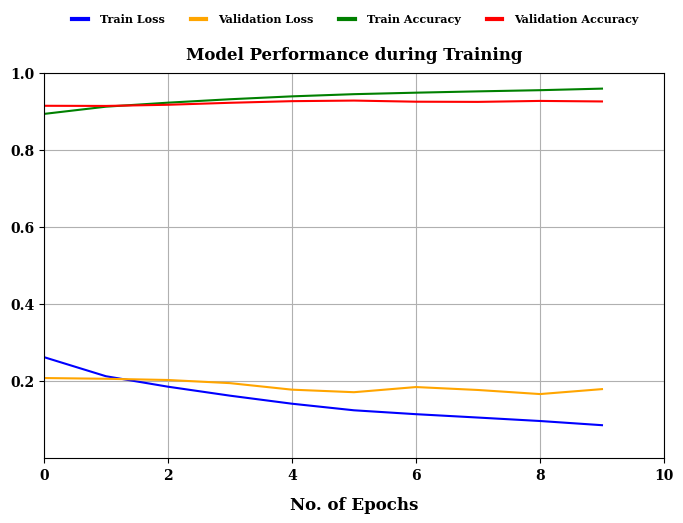

In [26]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(8, 5))

#Check history plots, one model at a time
history = Unet_history
# Plot Loss
train_loss, = plt.plot(history.history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(history.history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')


# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# Set x-axis ticks font properties
plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

# Set y-axis ticks font properties
plt.yticks(np.linspace(0.2, 1, num=5), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
plt.xlim(0, len(history.history['loss']))
plt.ylim(0, 1)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


# Display gridlines for better readability
plt.grid(True)
plt.show()


# **Checking prediction on images from Test Dataset**

1/1 [==============================] - 2s 2s/step


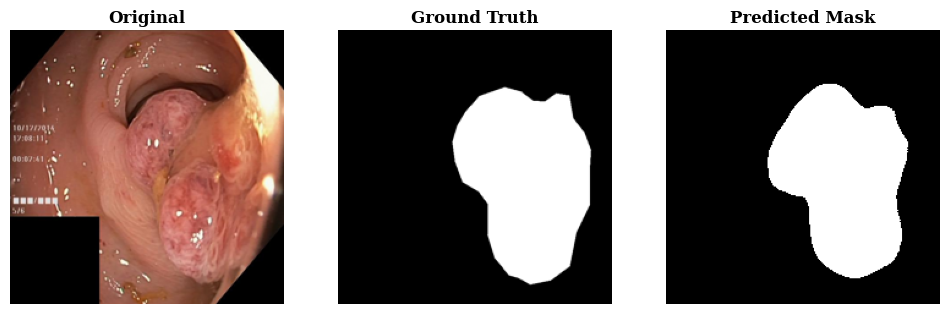

In [27]:
import random
import matplotlib.pyplot as plt

model = model_Unet_plus

test_img_number = 44  # Change the index number here...

test_img = test_image_data[test_img_number]
ground_truth = test_mask_data[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(test_img)
axs[0].set_title('Original', fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
axs[0].axis('off')

axs[1].imshow(ground_truth[:, :, 0], cmap='gray')
axs[1].set_title('Ground Truth', fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
axs[1].axis('off')

prediction_visual = axs[2].imshow(prediction, cmap='gray')
axs[2].set_title('Predicted Mask', fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})
axs[2].axis('off')
# Save the plotted images
plt.savefig('/content/drive/MyDrive/prediction_images.pdf')  # Modify the file name as needed
plt.show()


# **Segmentation Evaluation Metrics**
* Intersection over Union (IoU)
* Dice Coefficient
* Pixel Accuracy
* Surface Dice Overlap
* Modified Hausdorff Distance

In [28]:
from sklearn.metrics import precision_recall_fscore_support
from skimage.measure import label, regionprops
from scipy.spatial.distance import directed_hausdorff

# Initialize lists to store evaluation metrics for each image
IoU_values = []
dice_coefficient_values = []
pixel_accuracy_values = []
modified_hausdorff_distance_values = []

n_classes = 2  # Assuming binary segmentation

for img in range(0, test_image_data.shape[0]):
    temp_img = test_image_data[img]
    ground_truth = test_mask_data[img]
    temp_img_input = np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

    # Intersection over Union (IoU)
    intersection = np.logical_and(ground_truth[:, :, 0], prediction)
    union = np.logical_or(ground_truth[:, :, 0], prediction)
    iou = np.sum(intersection) / np.sum(union)
    IoU_values.append(iou)

    # Dice Coefficient
    dice = (2 * np.sum(intersection)) / (np.sum(ground_truth[:, :, 0]) + np.sum(prediction))
    dice_coefficient_values.append(dice)

    # Pixel Accuracy
    pixel_accuracy = np.sum(intersection) / np.sum(ground_truth[:, :, 0])
    pixel_accuracy_values.append(pixel_accuracy)


    # Modified Hausdorff Distance
    hausdorff_distance = directed_hausdorff(ground_truth[:, :, 0], prediction)[0]
    modified_hausdorff_distance_values.append(hausdorff_distance)

# Calculate mean values for all metrics
mean_IoU = np.mean(IoU_values)
mean_dice_coefficient = np.mean(dice_coefficient_values)
mean_pixel_accuracy = np.mean(pixel_accuracy_values)
mean_modified_hausdorff_distance = np.mean(modified_hausdorff_distance_values)


1/1 [==============================] - 0s 28ms/step


In [29]:
surface_dice_overlap_values = []

n_classes = 2  # Assuming binary segmentation

for img in range(0, test_image_data.shape[0]):
    temp_img = test_image_data[img]
    ground_truth = test_mask_data[img]
    temp_img_input = np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

    # Surface Dice Overlap (Assuming binary images)
    labeled_true = label(ground_truth[:, :, 0])
    labeled_pred = label(prediction)
    props_true = regionprops(labeled_true)
    props_pred = regionprops(labeled_pred)

    # Calculate Surface Dice Overlap for each pair of regions
    dice_overlap_sum = 0
    pairs_count = 0

    for p in props_true:
        for q in props_pred:
            intersection = np.logical_and(labeled_true == p.label, labeled_pred == q.label)
            if np.sum(intersection) > 0:
                dice_overlap = 2 * np.sum(intersection) / (np.sum(labeled_true == p.label) + np.sum(labeled_pred == q.label))
                dice_overlap_sum += dice_overlap
                pairs_count += 1

    surface_dice_overlap = dice_overlap_sum / pairs_count if pairs_count > 0 else 0
    surface_dice_overlap_values.append(surface_dice_overlap)

# Calculate mean value for surface dice overlap
mean_surface_dice_overlap = np.mean(surface_dice_overlap_values)



1/1 [==============================] - 0s 28ms/step


# **Print mean values of Evaluation metrics**

In [30]:
# Print mean values
print("Mean Intersection over Union (IoU):", mean_IoU)
print("Mean Dice Coefficient:", mean_dice_coefficient)
print("Mean Pixel Accuracy:", mean_pixel_accuracy)
print("Mean Modified Hausdorff Distance:", mean_modified_hausdorff_distance)
print("Mean Surface Dice Overlap:", mean_surface_dice_overlap)

Mean Intersection over Union (IoU): 0.6295771655173882
Mean Dice Coefficient: 0.7595598265226273
Mean Pixel Accuracy: 0.7814638830943494
Mean Modified Hausdorff Distance: 4.449422653003987
Mean Surface Dice Overlap: 0.7035840254065306
